# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [-] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [ ] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [ ] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [ ] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compare to theory 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps
from numba import jit
import hankl
import multiprocessing as mp


#camb
import camb 
from camb import model, initialpower

## Theory power spectrum for Gaussian random field

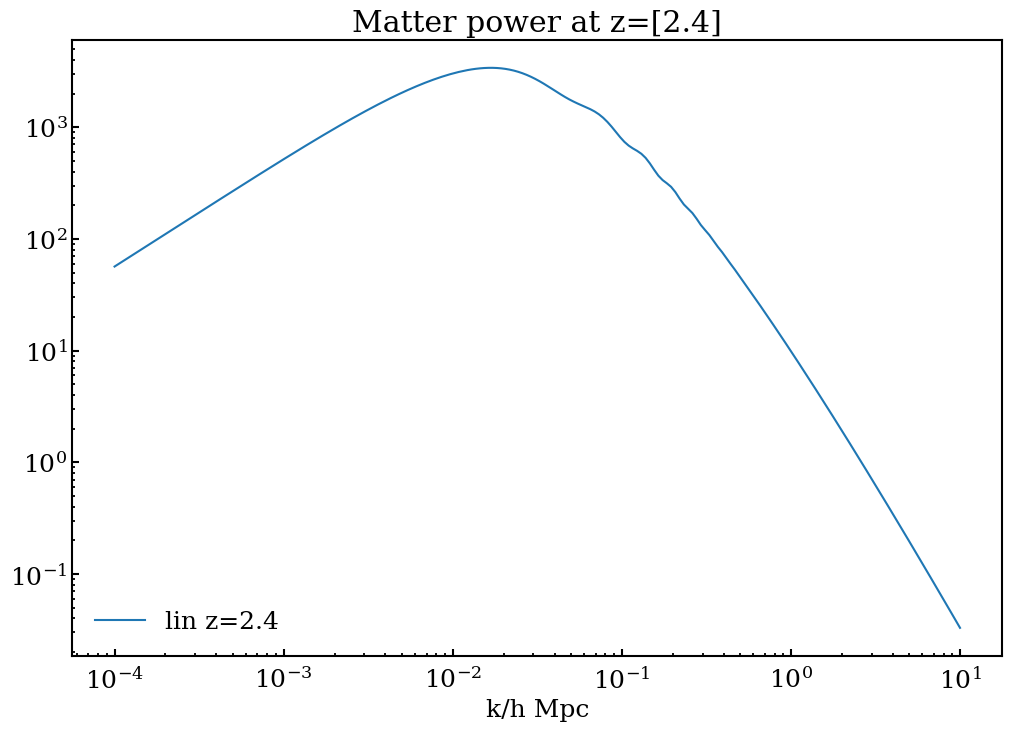

In [2]:
### Generate theory power spectrum
## get CAMB linear matter power

h = 0.6770
Omega_b = 0.04904
Omega_m = 0.3147
ns = 0.96824
As = 2.10732e-9
mnu = 0.0
H0 = h*100
ombh2 = Omega_b*h**2.
omch2 = (Omega_m-Omega_b)*h**2.

pars = camb.CAMBparams()
#z=2.4 approx eBOSS DR16 effective redshift
z=[2.4]
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu)
pars.InitPower.set_params(ns=ns,As=As)
#Note non-linear corrections couples to smaller scales than you want 
pars.set_matter_power(redshifts=z, kmax=50)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 200)

for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], ls = line)
#plt.plot(kh_lin, Plin(kh_lin), 'C2-.')
plt.xlabel('k/h Mpc');
plt.legend(['lin z={:1.1f}'.format(z[0]), 'nbodykit Plin'], loc='lower left');
plt.title('Matter power at z=%s'%z);

def get_multipoles(bias, beta, pk):
    # monopole
    p0 = bias**2 * (1. + 2.*beta/3. + beta**2. / 5. ) * pk
    # quadrupole
    p2 = bias**2 * (4.*beta/3. + 4.*beta**2. / 7.) * pk
    # hexadecapole
    p4 = bias**2 * (8. * beta**2. / 35.) * pk
    return p0, p2, p4

In [3]:

### Calculate Fourier modes
# N=256 #number of cells (relatively large to try and limit discreteness effects)
N=512 # high res

L=1380. # box size in [h^-1.Mpc] cell size*n_x
bins = 30 #number of bins in k from which the power spectrum P will be estimated

k_f=2 * np.pi/L
print('Fundamental mode k_f=',k_f)

kfft=np.fft.fftfreq(N)*2.0*np.pi/L*N # deal with frequencies corresponding to FFT 
kminfft=np.amin(np.abs(kfft)) # find min frequency (probably zero)
kmaxfft=np.amax(np.abs(kfft)) # find max frequencey (Nyquist) - can be negative
kmax=np.sqrt(3)*kmaxfft # max mode k 
print('max mode k_f=',kmax)
kmin=kminfft # min mode k 

kNy=kmaxfft; print('Nyquist frequency:', kNy) # Nyquist frequency
k_bins = np.geomspace(1.e-4,kmax,bins+1)
k_bin_ctrs=(k_bins[1:]+k_bins[:-1])/2.0

print('ratio of Nyquist to fundamental freq',kNy/k_f) # with N=128
print('ratio of max to Nyquist freq',kmax/kNy) # with np.sqrt(3) ratio

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774


### Define power spectrum functions

In [4]:
@jit(nopython=True)
def compute_mu3d(n):
    print('compute mu = k_los / |k|')
    mu  = np.ones((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu[i,j,l]=kz/(1e-10+k_sum) # angle to z axis
    return mu

@jit(nopython=True)
def get_ks3d(L, n):
    kk  = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                kk[i,j,l]=k_sum
    return kk


@jit(nopython=True)
def get_amplitudes3d(L, n, Pk, beta, mu):
    areal = np.zeros((n,n,n))
    aim = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(np.int32(n/2+1)):
            #for l in range(n):
                pk = Pk[i,j,l]
                if (i==0 or i==np.int32(n/2)) and (j==0 or j==np.int32(n/2)) and (l==0 or l==np.int32(n/2)):
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   = 0 # real value for k=0 and Nyquist frequency at i,j,l = N/2
                else:
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2) #1./np.sqrt(2) * --> no need for this factor
                    areal[(n-i)%n][(n-j)%n][(n-l)%n] = areal[i,j,l]
                    aim[(n-i)%n][(n-j)%n][(n-l)%n]   = -aim[i,j,l]
    a = areal + 1.0j*aim
    return a #(h/Mpc)**3

@jit(nopython=True)
def compute_amplitudes3d(L, n, Pk, bias, beta, aniso):
    print('Include anisotropies', aniso)
    if aniso:
        mu = compute_mu3d(n)
    else:
        mu  = np.zeros((n,n,n))
        beta = 0.
    print('bias', bias)
    print('beta', beta)
    print('mu', mu[:2,:2,:2].ravel())
    return bias * get_amplitudes3d(L, n, Pk, beta, mu) #(h/Mpc)**3

def density_field(a, L, n, d=3):
    #dimension d=3
    print('Transforming amplitudes to density field')
    boxvol = float(L)**d
    pix    = (float(L)/float(n))**d
    dens   = np.fft.ifftn(a) * boxvol ** (1./2.) / pix
    #dens *= 1./np.sqrt(2*np.pi)**d
    print('dens:',np.mean(dens), np.min(dens), np.max(dens))
    #assert(np.max(abs(np.imag(dens)))<1e-10, 'Density field should be entirely real')
    return np.real(dens)


### Compute amplitudes and k 
- $P_F(k, \mu, z) = b_F(z)^2 (1+\beta_F(z)\mu^2)^2 P_{L}(k)$, thus, for the amplitudes compute $\delta_F \propto b * (\delta_m + \beta \mu^2 \delta_m)$
- coadd both boxes

In [5]:
add_rsd = True
# define bias and beta
my_bias = 1.
my_beta = 1.5
plin = interp1d(kh_lin, pk_lin[0,:], fill_value="extrapolate")
all_ks_3d = get_ks3d(L, N)
pk_all = plin(all_ks_3d)
# set seed 
np.random.seed(100)

# compute isotropic box (no beta!)
amplitudes_iso         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=0., aniso=False)
amplitudes_squared_iso = np.real(amplitudes_iso*np.conj(amplitudes_iso))

#compute density field from amplitudes
dens_iso = density_field(amplitudes_iso, L, N)
# set seed 
np.random.seed(100)

amplitudes_aniso       = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
amplitudes_squared_tot   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))

#compute density field from amplitudes
dens = density_field(amplitudes_aniso, L, N)


Include anisotropies False
bias 1.0
beta 0.0
mu [0. 0. 0. 0. 0. 0. 0. 0.]
Transforming amplitudes to density field
dens: (2.0424620838178867e-07+0j) (-4.837912468791386+0j) (4.817674795244333+0j)
Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (1.4810874704222276e-05+0j) (-7.167921328301112+0j) (7.6803177751622345+0j)


## Compute power spectrum 
- Spherically average amplitudes squared in k-shells


In [6]:
@jit(nopython=True)
def compute_Pk(n, amplitudes_squared):
    Phat = np.zeros(bins)
    Phat2 = np.zeros(bins)
    Phat4 = np.zeros(bins)
    k_eff = np.zeros(bins)
    counts = np.zeros(bins) # initialize counts of mode
    totcounts=0
    for i in range(n):
        for j in range(n): 
            for l in range(n):
                totcounts+=1
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu   = kz/(1e-10+k_sum) # angle to z axis
                l2mu = (3.*mu**2.-1.)/2.
                l4mu = (35.*mu**4.-30.*mu**2. + 3.)/8.

                for m in range(bins):
                    if (k_sum>=k_bins[m] and k_sum<k_bins[m+1]): # check if in bin
                        Phat[m]  += amplitudes_squared[i,j,l] # measure monopole
                        Phat2[m] += amplitudes_squared[i,j,l]*(2.*2.+1.)*l2mu # measure quadrupole
                        Phat4[m] += amplitudes_squared[i,j,l]*(2.*4.+1.)*l4mu # measure hexadecapole
                        k_eff[m] += k_sum
                        counts[m]+= 1.

    # normalization 
    Phat /=counts # P over number of modes
    Phat2/=counts
    Phat4/=counts
    k_eff/=counts

    print(sum(counts))
    print(totcounts)
    print(N**3)
    return k_eff, Phat, Phat2,Phat4, counts,totcounts


In [7]:
# compute power spectra
k_eff_iso, Phat_iso, Phat2_iso, Phat4_iso,counts,totcounts = compute_Pk(N, amplitudes_squared_iso)
k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(N, amplitudes_squared_tot)
# normalize power spectrum
k_diff = k_bins[1:]-k_bins[:-1]
dk=k_bins[1]-k_bins[0]

V   = L ** 3 # volume of box
N_c = N # number of cells
V_k = 4.0 * np.pi * (k_bins[1:]**3.0-k_bins[:-1]**3.0)/3.0 # 

V_f=k_f**3.0

N_k = V_k / V_f

norm_const = V / (N_c**6) # P=1/V <\delta \delta>, but each \delta needs units of volume V/N_c^3

# normalize P(k)
#Phat_iso_final = Phat_iso*norm_const
#Phat2_iso_final = Phat2_iso*norm_const
### compute theory


134217726.0
134217728
134217728
134217726.0
134217728
134217728


In [8]:
# theory power spectrum isotropic --> beta = 0
p0_iso, p2_iso, p4_iso = get_multipoles(bias=my_bias, beta=0.,      pk=pk_lin[0,:])
# theory power spectrum anisotropic --> beta = my_beta
p0, p2, p4             = get_multipoles(bias=my_bias, beta=my_beta, pk=pk_lin[0,:])


In [9]:
'''
# try this for 10 realisations
Phat0 = []
Phat2 = []
Phat4 = []
for i in range(10):
    # set seed 
    np.random.seed(10*i)

    amplitudes_aniso       = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
    amplitudes_squared_tot   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))
    k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(N, amplitudes_squared_tot)
    Phat0.append(Phat_tot)
    Phat2.append(Phat2_tot)
    Phat4.append(Phat4_tot)
Phat0 = np.array(Phat0)
Phat2 = np.array(Phat2)
Phat4 = np.array(Phat4)

plt.plot(kh_lin, kh_lin*p0, 'b--', label=r'$\ell=0$ (aniso)')
plt.plot(kh_lin, kh_lin*p2, 'g--', label=r'$\ell=2$ (aniso)')
plt.plot(kh_lin, kh_lin*p4, 'm--', label=r'$\ell=4$ (aniso)')
plt.errorbar(k_eff_tot, k_eff_tot*Phat0.mean(0),yerr=k_eff_tot*Phat0.std(0), c='b',ls='',marker='o',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.errorbar(k_eff_tot, k_eff_tot*abs(Phat2.mean(0)),yerr=k_eff_tot*Phat2.std(0), c='g',ls='',marker='o',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.errorbar(k_eff_tot, k_eff_tot*abs(Phat4.mean(0)), yerr=k_eff_tot*Phat4.std(0),c='m',ls='',marker='o',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()
'''

"\n# try this for 10 realisations\nPhat0 = []\nPhat2 = []\nPhat4 = []\nfor i in range(10):\n    # set seed \n    np.random.seed(10*i)\n\n    amplitudes_aniso       = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)\n    amplitudes_squared_tot   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))\n    k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(N, amplitudes_squared_tot)\n    Phat0.append(Phat_tot)\n    Phat2.append(Phat2_tot)\n    Phat4.append(Phat4_tot)\nPhat0 = np.array(Phat0)\nPhat2 = np.array(Phat2)\nPhat4 = np.array(Phat4)\n\nplt.plot(kh_lin, kh_lin*p0, 'b--', label=r'$\\ell=0$ (aniso)')\nplt.plot(kh_lin, kh_lin*p2, 'g--', label=r'$\\ell=2$ (aniso)')\nplt.plot(kh_lin, kh_lin*p4, 'm--', label=r'$\\ell=4$ (aniso)')\nplt.errorbar(k_eff_tot, k_eff_tot*Phat0.mean(0),yerr=k_eff_tot*Phat0.std(0), c='b',ls='',marker='o',label=r'$\\hat{P}_{\\ell=0}^{\\mathrm{aniso}}(k)$')\nplt.errorbar(k_eff_tot, k_eff_tot*abs(Phat2.mean(0)),yerr=k_ef

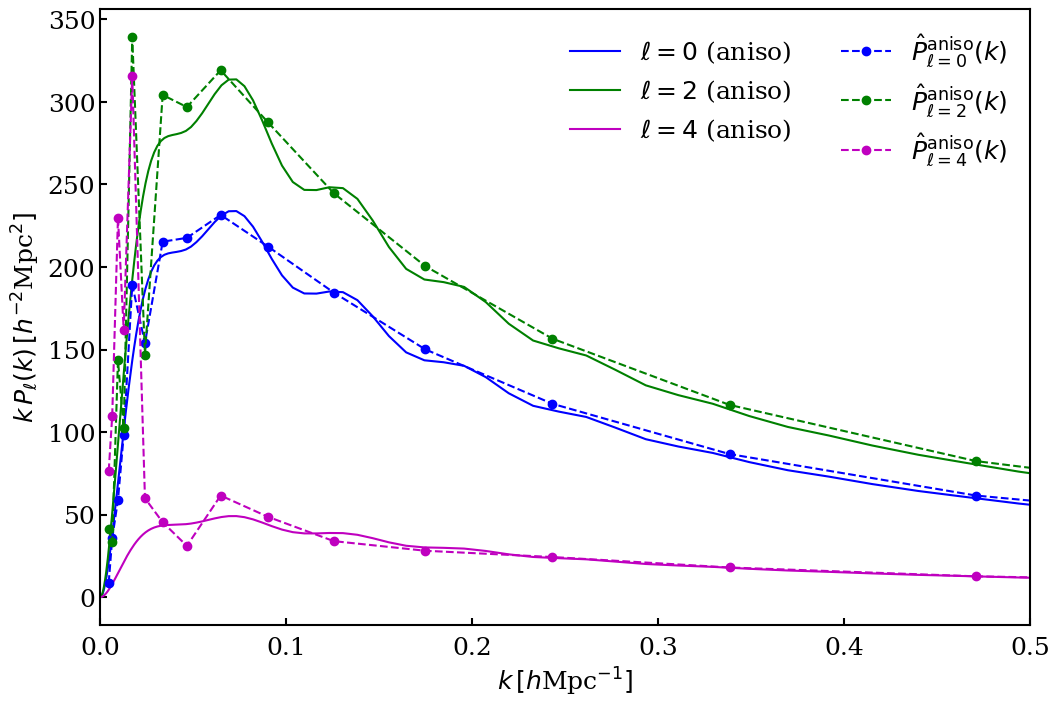

In [10]:
### compare theory to measurement

plt.plot(kh_lin, kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(kh_lin, kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(kh_lin, kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
plt.plot(k_eff_tot, k_eff_tot*Phat_tot, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat2_tot), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat4_tot), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()


## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- (HIPSTER natively computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$)
- We just use a small number of skewers here for testing


In [11]:
if add_rsd:
    iso_str = '_aniso'
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
else:
    iso_str = ''
    # compute isotropic box (no beta!)
    print('isotropic box')
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=0., aniso=False)

amplitudes_squared = np.real(amplitudes*np.conj(amplitudes))
#compute density field from amplitudes
dens = density_field(amplitudes, L, N)

Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (2.2873932414962727e-05+0j) (-7.309476641017972+0j) (7.506049410149793+0j)


### extract full length skewers through the box

In [31]:
coords = np.meshgrid(*[np.linspace(0,L,N) for _ in range(3)])
Nskew = int(1e3)
inds = np.unique(np.random.randint(0,N,size=(Nskew,2)),axis=0)
Nskew = len(inds)
print("N_skew = %d / %d"%(Nskew,N**2))

# DELTA + 1
dens_lya = 1.+dens[inds[:,0],inds[:,1],:]
skewer_field = dens_lya.ravel()
# take skewers in z-direction
shift = 0.
print("Displacing box by %.3e"%shift)
all_x = coords[0][inds[:,0],inds[:,1],:].ravel()
all_y = coords[1][inds[:,0],inds[:,1],:].ravel()
all_z = coords[2][inds[:,0],inds[:,1],:].ravel()+shift
all_tid = (np.ones(N)[None,:]*np.arange(len(inds))[:,None]).ravel()
all_w_rand = np.ones_like(all_x,dtype='float')
all_w_gal  = np.asarray(skewer_field,dtype='float')
all_hpx = np.zeros_like(all_x,dtype='float')
skewer_str=''


N_skew = 996 / 262144
Displacing box by 0.000e+00


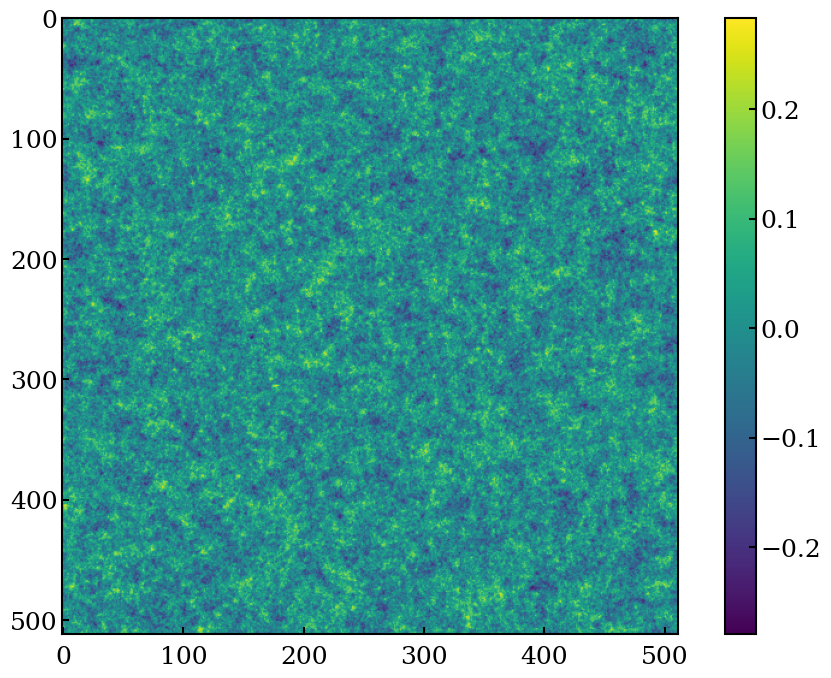

In [34]:
plt.imshow(dens.mean(2));plt.colorbar();plt.show()

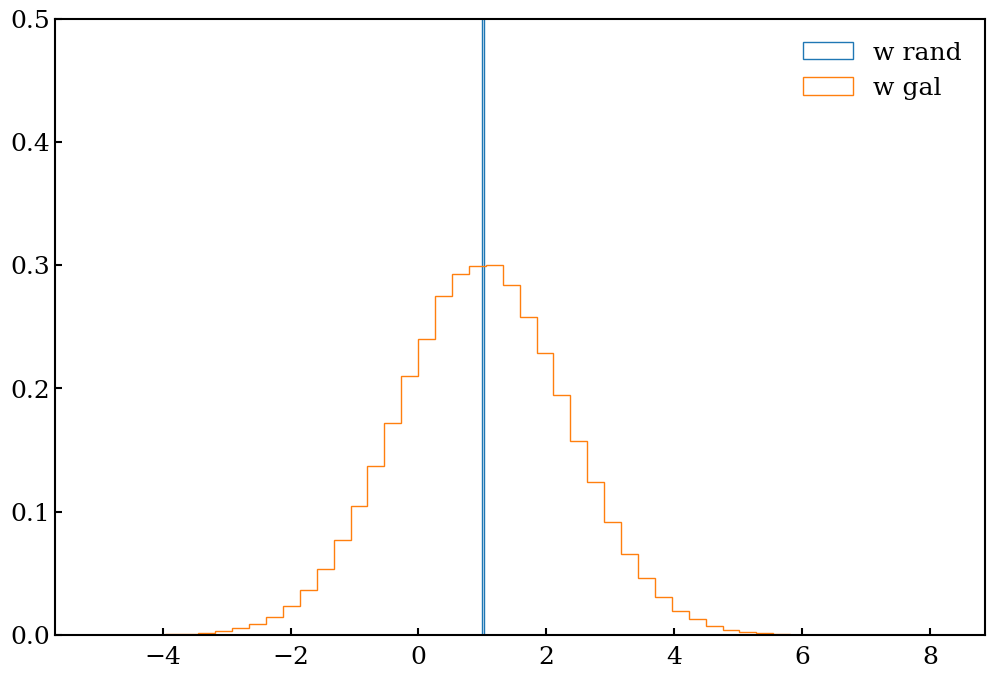

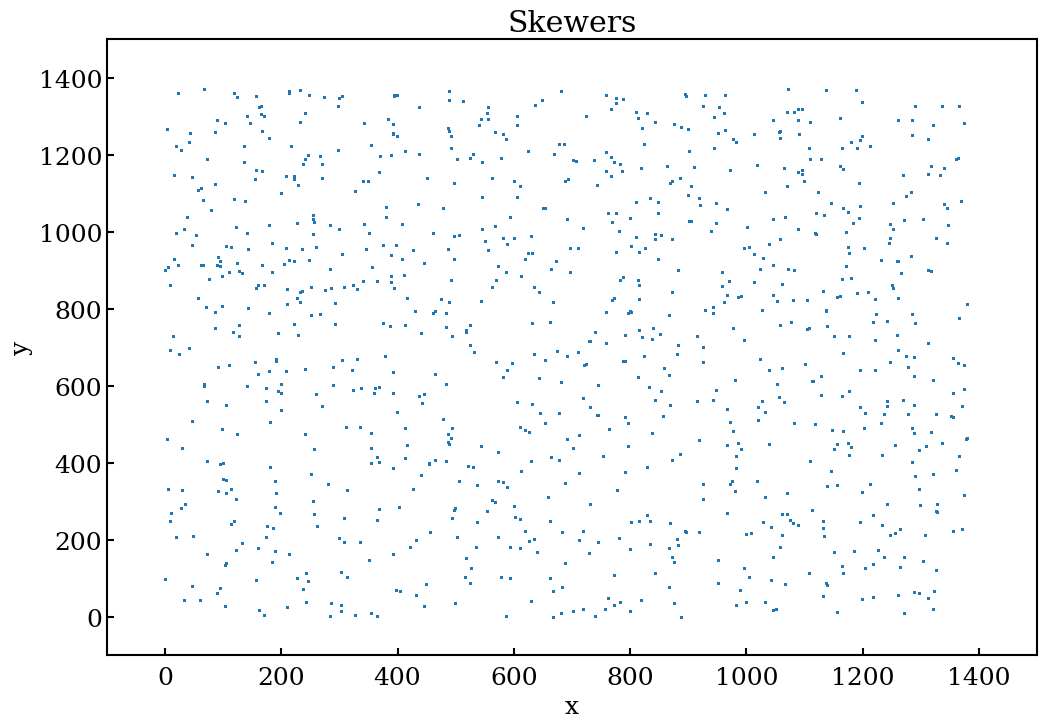

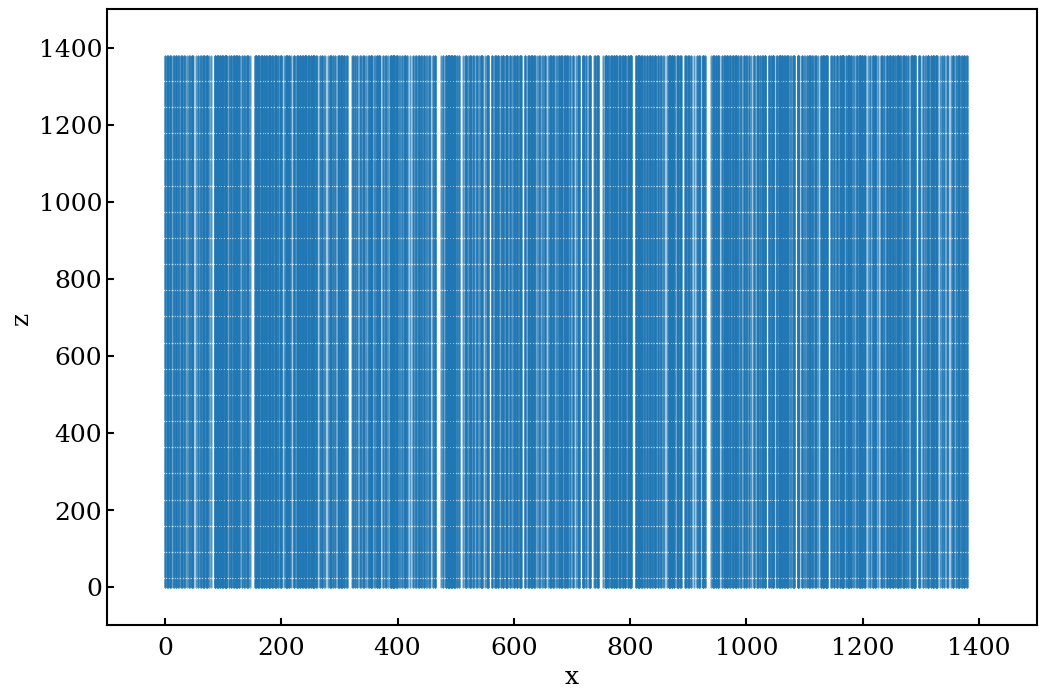

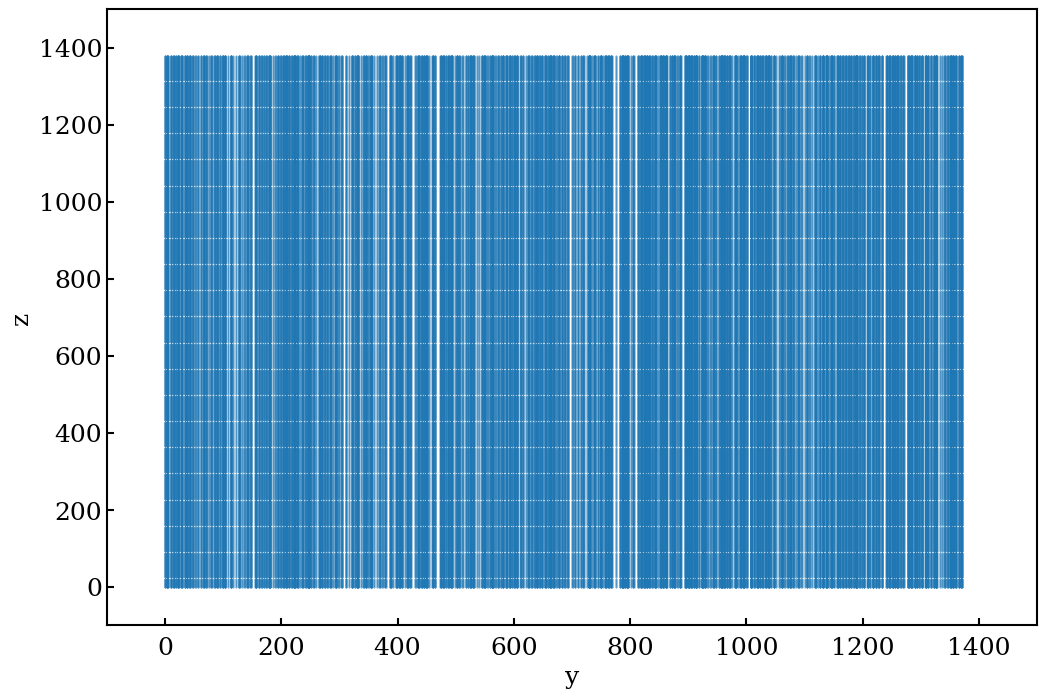

In [18]:
### Plot distribution of weights
plt.hist(all_w_rand,density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal,density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

#### Visually check if skewers are taken through box
plt.title('Skewers')
plt.scatter(all_x[:],all_y[:],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.xlim(-100, 1500);plt.ylim(-100, 1500);plt.show()
plt.scatter(all_x[:],all_z[:],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.xlim(-100, 1500);plt.ylim(-100+shift, 1500+shift);plt.show()
plt.scatter(all_y[:],all_z[:],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.xlim(-100, 1500);plt.ylim(-100+shift, 1500+shift);plt.show()

## 2D case
- [ ] project 3D field along LOS (z-axis)
- [ ] compute Ra,Dec in rad for {x,y} positions
- [ ] compute theory C_ell for my GRFs

In [35]:
do_plots = True

In [36]:
def coord_transform(x,y,z):
    # Convert the X,Y,Z coordinates into Ra,Dec,comoving_distance
    # Shamelessly stolen from astropy
    xsq = x ** 2.
    ysq = y ** 2.
    zsq = z ** 2.

    com_dist = (xsq + ysq + zsq) ** 0.5
    s = (xsq + ysq) ** 0.5

    Ra = np.arctan2(y, x)*180./np.pi+180.
    Dec = np.arctan2(z, s)*180./np.pi

    return com_dist, Ra, Dec


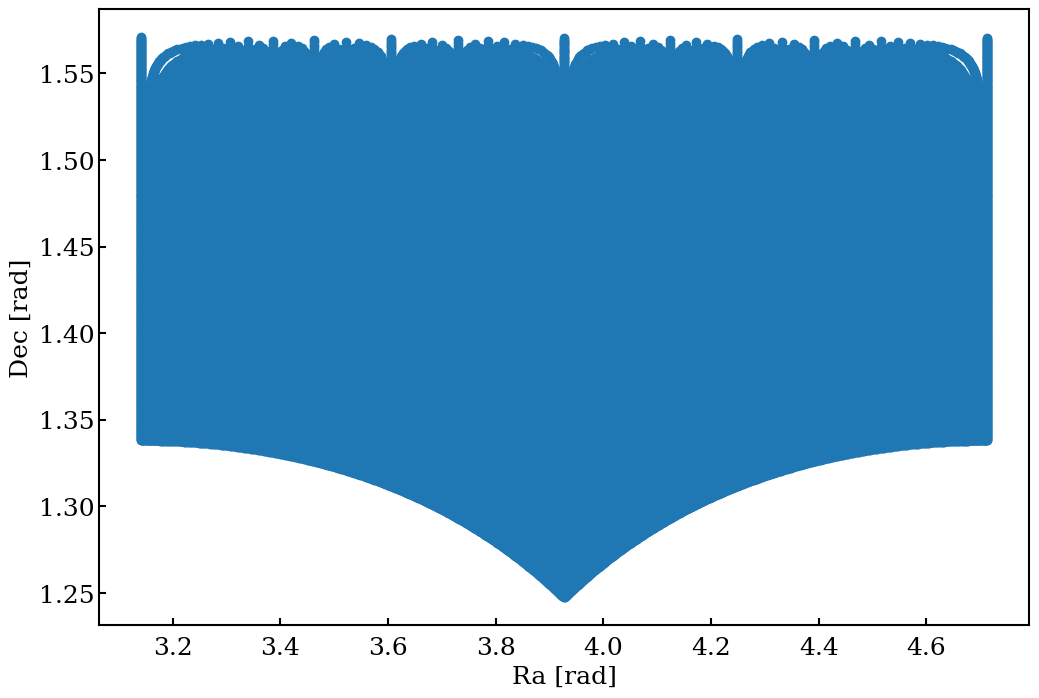

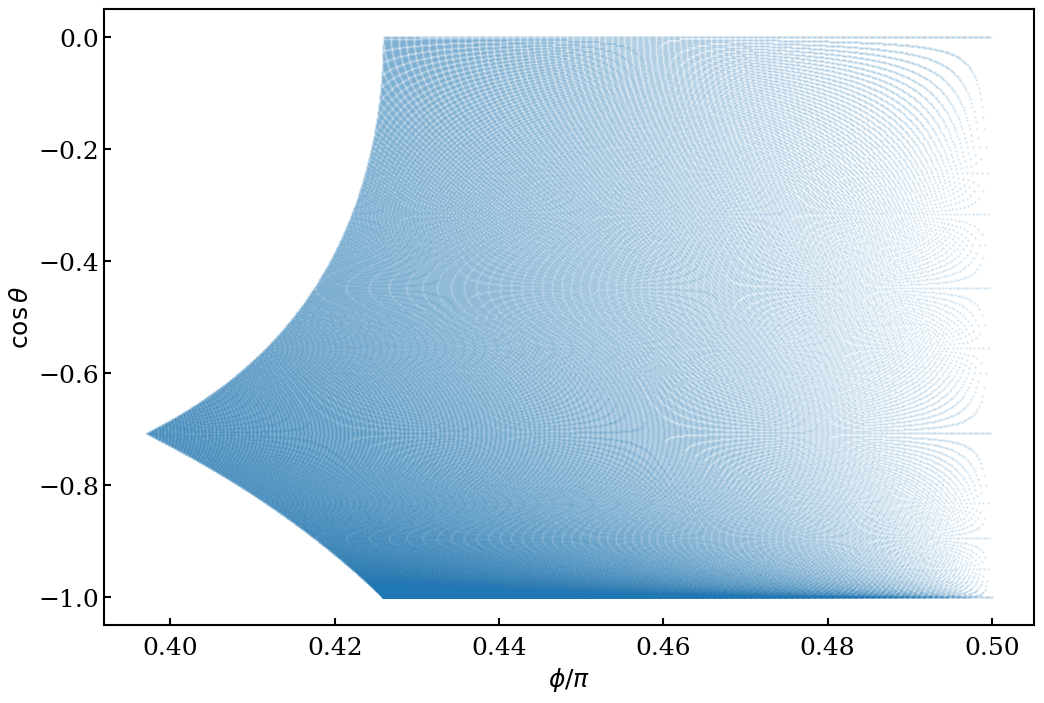

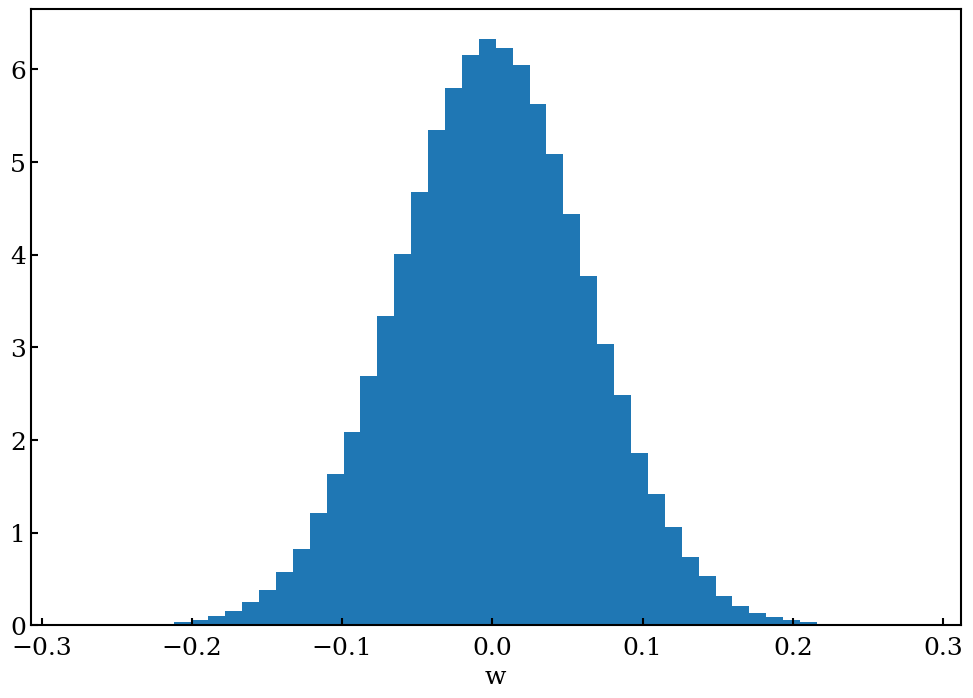

In [77]:
#mean of the box and use all pixels first 
w = dens.mean(2).ravel()
x = coords[0][:,:,0].ravel()
y = coords[1][:,:,0].ravel()

# now convert cartesian to sky coordinates

# Convert coordinates to spherical coordinates
# assume that the box is at redshift 2.4
box_distance = results.comoving_radial_distance(2.4)
_,Ra,Dec = coord_transform(x,y,np.ones_like(x)*box_distance);
tdata,pdata,wdata = np.deg2rad(Ra), np.deg2rad(Dec),w
trand,prand,wrand = np.deg2rad(Ra), np.deg2rad(Dec),np.ones_like(w)

if do_plots: 
    plt.figure();plt.scatter(tdata,pdata);plt.xlabel('Ra [rad]');plt.ylabel('Dec [rad]');plt.show()
    plt.figure();plt.scatter(pdata/np.pi,np.cos(tdata), s=1,c='C0',alpha=0.1,label='Rand',rasterized=False);plt.xlabel(r'$\phi/\pi$');plt.ylabel(r'$\cos\theta$');plt.show()
    plt.hist(wdata, bins=50, density=True);plt.xlabel('w');plt.show()    

# # matrix of my skewers in (no z bins x no QSOs)

# mask_tid = np.unique(all_tid, return_index=True)[1]
# # the {x,y} corredinates of my box are:
# x, y, w = all_x[mask_tid], all_y[mask_tid], dens_lya.mean(1)
# # now convert cartesian to sky coordinates

# # Convert coordinates to spherical coordinates
# # assume that the box is at redshift 2.4
# box_distance = results.comoving_radial_distance(2.4)
# _,Ra,Dec = coord_transform(x,y,np.ones_like(x)*box_distance);
# tdata,pdata,wdata = np.deg2rad(Ra), np.deg2rad(Dec),w
# trand,prand,wrand = np.deg2rad(Ra), np.deg2rad(Dec),np.ones_like(w)

# if do_plots: 
#     plt.figure();plt.scatter(tdata,pdata);plt.xlabel('Ra [rad]');plt.ylabel('Dec [rad]');plt.show()
#     plt.hist(wdata, bins=50, density=True);plt.xlabel('w');plt.show()    

### use directSHT to compute $C_{ell}$

In [56]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht/')
from sht.sht                import DirectSHT
#from sht.mocks              import LogNormalMocks
#from sht.mask_deconvolution import MaskDeconvolution

env: JAX_ENABLE_X64=True


In [57]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.625


In [60]:
len(trand), len(prand),len(wrand)

(262144, 262144, 262144)

In [78]:
trand.max()

4.71238898038469

In [79]:
trand.min()

3.141592653589793

In [80]:
np.all((trand >= 0) & (trand > np.arccos(sht.xmax)) & (trand < np.arccos(-sht.xmax)))

False

In [69]:
np.arccos(-sht.xmax)

2.2459278597319283

In [70]:
np.arccos(sht.xmax)

0.895664793857865

In [58]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.7679367065429688  seconds.
Reshaping took  0.6826035976409912  seconds.
Precomputing vs took  1.2927017211914062  seconds.
Computing alm's took  1.6983461380004883  seconds.
Sorting & digitizing took  0.7360396385192871  seconds.
Reshaping took  0.5660829544067383  seconds.
Precomputing vs took  0.9812583923339844  seconds.
Computing alm's took  1.4714653491973877  seconds.


AssertionError: theta must be in [ACos[xmax],ACos[-xmax]).

In [ ]:
plt.loglog(wl   ,label='no shot noise for Lya')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
#plt.savefig('harmonic_window.pdf')

In [ ]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

In [ ]:
# Plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('harmonic_wbl.pdf')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1,figsize=(8,8))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
#plt.savefig('harmonic_mll.pdf')

In [ ]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [ ]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [ ]:
print(binned_ells)
print(hdif_decoupled)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

### Fourier transform along each LOS 
- the box has dimensions $(N \times N \times N)$ where $N$=512. 
- we choose $\textit{parallel}$ along z 
    - FFT each skewer


In [ ]:
# dens_lya - weights describing the box: wgal = w*(1+delta_F= = 1*(1+delta_F)
# approx. 1000 skewers

delta_3D_FFT = np.fft.fftn(dens_lya)
print(delta_3D_FFT.shape)

(998, 512)
